## Overview

- **Main ideas:**
    - This notebook makes the `CRUNCEP7` data for variable of `total incident solar radiation` (6-hour time resolution) spatially compatible with `ERA-INTERIM` data grid: 
        - CRUNCEP7:
            - lat: 360, lon: 720; 0.50 x 0.50 degrees; global.
        - ERA-INTERIM: 
            - lat: 241, lon: 480; 0.75 x 0.75 degrees; global. 

## Initial Setup

In [1]:
# Load packages
import sys
import glob
import os

import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dask.diagnostics import ProgressBar

xr.set_options(display_style="text")

%matplotlib inline

In [2]:
print("Python:", sys.version)
print("Xarray:", xr.__version__)
print("Pandas:", pd.__version__)

Python: 3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]
Xarray: 0.16.0
Pandas: 1.0.2


In [3]:
# My repository.
repository = "/home/alex/Dropbox/repositories/cdlearn/"

In [4]:
%%time

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Work in progress.
from cdlearn.maps import south_america_months

CPU times: user 5.85 s, sys: 970 ms, total: 6.82 s
Wall time: 19.5 s


In [5]:
# Data folder.
MAIN_FOLDER = "/media/alex/ALEXDATA/data_sets/CRUNCEP7/"

# Put regridded data here.
OUTPUT_FOLDER = "/media/alex/ALEXDATA/data_sets/CRUNCEP7/"

# One file for each month.
FILES_PATHS = sorted([
    os.path.join(MAIN_FOLDER, FILE) for FILE in os.listdir(MAIN_FOLDER) 
    if ("Solr" in FILE and "regridded" not in FILE)
])

In [1]:
# South America.
loni, lonf, lati, latf = -90, -30, -60, 20

## Explore single file

In [7]:
%%time

# Lazy load. The chunks option make data as dask arrays instead of numpy arrays.
# So when transposing the data is not loaded into memory!
DS = xr.open_dataset(
    filename_or_obj=FILES_PATHS[0], 
    drop_variables=["EDGEE", "EDGEN", "EDGES", "EDGEW", "LATIXY", "LONGXY"],
    use_cftime=True,    
    chunks={}
)

# Now you can transpose without loading into memory.
DS = DS.transpose("time", "lat", "lon")

print(">>> Case title:\n" + DS.case_title)

# Show it.
print("\n>>> Data:")
print(DS.FSDS)

>>> Case title:
CRUNCEP 6-Hourly Atmospheric Forcing: Incoming Solar.  Missing values filled with 1948 Qian data interpolated by datm to CRUNCEP grid.  See CRUNCEP_Landmask.nc in /glade/p/cesm/lmwg/atm_forcing.datm7.cruncep_qianFill.0.5d.V7.c160715 for valid (not filled) CRUNCEP data.

>>> Data:
<xarray.DataArray 'FSDS' (time: 124, lat: 360, lon: 720)>
dask.array<open_dataset-e04260f5e528d943495dacaf9d0c23fdFSDS, shape=(124, 360, 720), dtype=float32, chunksize=(124, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 ... 358.25 358.75 359.25 359.75
  * time     (time) object 1980-01-01 00:00:00 ... 1980-01-31 18:00:00
Attributes:
    long_name:  total incident solar radiation
    units:      W/m**2
    mode:       time-dependent
CPU times: user 44.4 ms, sys: 24.9 ms, total: 69.3 ms
Wall time: 94.5 ms


In [8]:
# Into memory.
with ProgressBar():
    DS = DS.load()

[########################################] | 100% Completed |  0.2s


## Make regridder file

In [9]:
# In accordance with ERA-INTERIM pos-processed data (after shifting longitudes from 0 ... 360
# to -180 ... 180).
NEW_GRID = xr.Dataset({
    "lat": (["lat"], np.arange(90.00, -90.01, -0.75)),
    "lon": (["lon"], np.arange(-180.00, 180.00, 0.75)),
})

# Show it.
print(NEW_GRID)

<xarray.Dataset>
Dimensions:  (lat: 241, lon: 480)
Coordinates:
  * lat      (lat) float64 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 ... 177.8 178.5 179.2
Data variables:
    *empty*


In [10]:
%%time

# Regridder object.
REGRIDDER = xe.Regridder(
    ds_in=DS, 
    ds_out=NEW_GRID, 
    method="bilinear", 
    periodic=True, 
    reuse_weights=True,
    filename="regridder_tisr.nc"
)

Reuse existing file: tisr_regridder.nc
CPU times: user 135 ms, sys: 71.5 ms, total: 207 ms
Wall time: 941 ms


In [11]:
%%time

# Regridded data.
DSreg = REGRIDDER(DS)

# Show it.
print(DSreg)

using dimensions ('lat', 'lon') from data variable FSDS as the horizontal dimensions for this dataset.
<xarray.Dataset>
Dimensions:  (lat: 241, lon: 480, time: 124)
Coordinates:
  * time     (time) object 1980-01-01 00:00:00 ... 1980-01-31 18:00:00
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 ... 177.8 178.5 179.2
  * lat      (lat) float64 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
Data variables:
    FSDS     (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 338.1 338.1 338.1
Attributes:
    regrid_method:  bilinear
CPU times: user 436 ms, sys: 103 ms, total: 539 ms
Wall time: 556 ms


## Compare original and regridded files

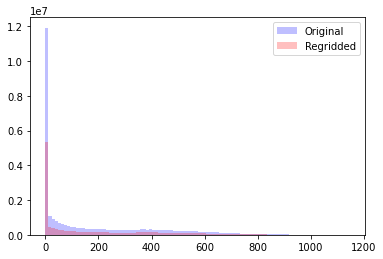

In [12]:
# Histograms.
plt.hist(DS.FSDS.values.flatten(), bins=100, color="blue", alpha=0.25, label="Original")
plt.hist(DSreg.FSDS.values.flatten(), bins=100, color="red", alpha=0.25, label="Regridded")
plt.legend();

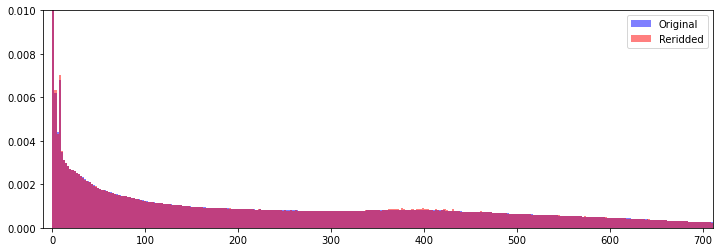

In [13]:
# Histograms.
plt.figure(figsize=(12, 4))
plt.hist(
    DS.FSDS.values.flatten(), 
    density=True, 
    bins=500, 
    color="blue", 
    alpha=0.5, 
    label="Original"
)
plt.hist(
    DSreg.FSDS.values.flatten(), 
    density=True, 
    bins=500, 
    color="red", 
    alpha=0.5, 
    label="Reridded"
)
plt.ylim((0, 0.01))
plt.xlim((-10, 710))
plt.legend();

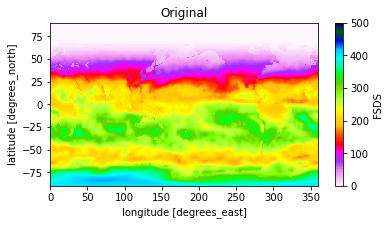

In [14]:
# Mean for the month.
plt.figure(figsize=(6, 3))
DS.FSDS.mean("time").plot(vmin=0, vmax=500, cmap=plt.cm.gist_ncar_r)
plt.title("Original");

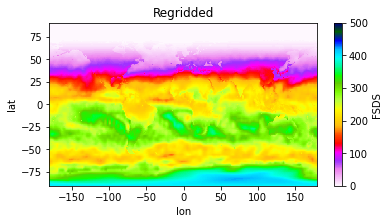

In [15]:
# Mean for the month.
plt.figure(figsize=(6, 3))
DSreg.FSDS.mean("time").plot(vmin=0, vmax=500, cmap=plt.cm.gist_ncar_r)
plt.title("Regridded");

## Create regridded files for all years

In [16]:
%%time

# Loop over input files.
for FILE_PATH in FILES_PATHS:
    
    # Extract input file name without extension.
    NAME = os.path.basename(FILE_PATH) # File name with extension.
    NAME = os.path.splitext(NAME)[0]   # File name withou extension.
    
    # Output file path.
    OUT_FILE_NAME = NAME + "_regridded" + ".nc4"
    OUT_FILE_PATH = OUTPUT_FOLDER + OUT_FILE_NAME   
    
    # Continue only if data file does not exist yet.
    if not os.path.isfile(OUT_FILE_PATH):
        
        # Message.
        print("Creating", OUT_FILE_PATH, "...")
        
        # Load data.
        DS = xr.open_dataset(
            filename_or_obj=FILE_PATH, 
            drop_variables=["EDGEE", 
                            "EDGEN", 
                            "EDGES", 
                            "EDGEW", 
                            "LATIXY", 
                            "LONGXY"],
            use_cftime=True,    
            chunks={}
        )

        # Now you can transpose without loading into memory.
        DS = DS.transpose("time", "lat", "lon")
              
        # Regrid data.
        DSreg = REGRIDDER(DS)
    
        # Export regridded data into the output folder. 
        DSreg.to_netcdf(path=OUT_FILE_PATH)

Creating /media/alex/ALEXDATA/data_sets/CRUNCEP7/clmforc.cruncep.V7.c2016.0.5d.Solr.1980-01_regridded.nc4 ...
using dimensions ('lat', 'lon') from data variable FSDS as the horizontal dimensions for this dataset.
Creating /media/alex/ALEXDATA/data_sets/CRUNCEP7/clmforc.cruncep.V7.c2016.0.5d.Solr.1980-02_regridded.nc4 ...
using dimensions ('lat', 'lon') from data variable FSDS as the horizontal dimensions for this dataset.
Creating /media/alex/ALEXDATA/data_sets/CRUNCEP7/clmforc.cruncep.V7.c2016.0.5d.Solr.1980-03_regridded.nc4 ...
using dimensions ('lat', 'lon') from data variable FSDS as the horizontal dimensions for this dataset.
Creating /media/alex/ALEXDATA/data_sets/CRUNCEP7/clmforc.cruncep.V7.c2016.0.5d.Solr.1980-04_regridded.nc4 ...
using dimensions ('lat', 'lon') from data variable FSDS as the horizontal dimensions for this dataset.
Creating /media/alex/ALEXDATA/data_sets/CRUNCEP7/clmforc.cruncep.V7.c2016.0.5d.Solr.1980-05_regridded.nc4 ...
using dimensions ('lat', 'lon') from d